In [1]:
##自分のgoogle driveをgoogle colaboratoryに接続
##実行すると、別windowが開き、googleアカウントへのアクセスを許可するか表示される
#"Mounted at /content/drive"が表示されれば成功

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


     |████████████████████████████████| 4.1 MB 5.2 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=c56f8c332c7b216da605cf2eeeaa1654547b1556da3079e3a5769a7e6712bc17
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib
TF version: 2.7.0
Hub version: 0.12.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is NOT AVAILABLE
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1024)              1529968   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 4)                 4100  

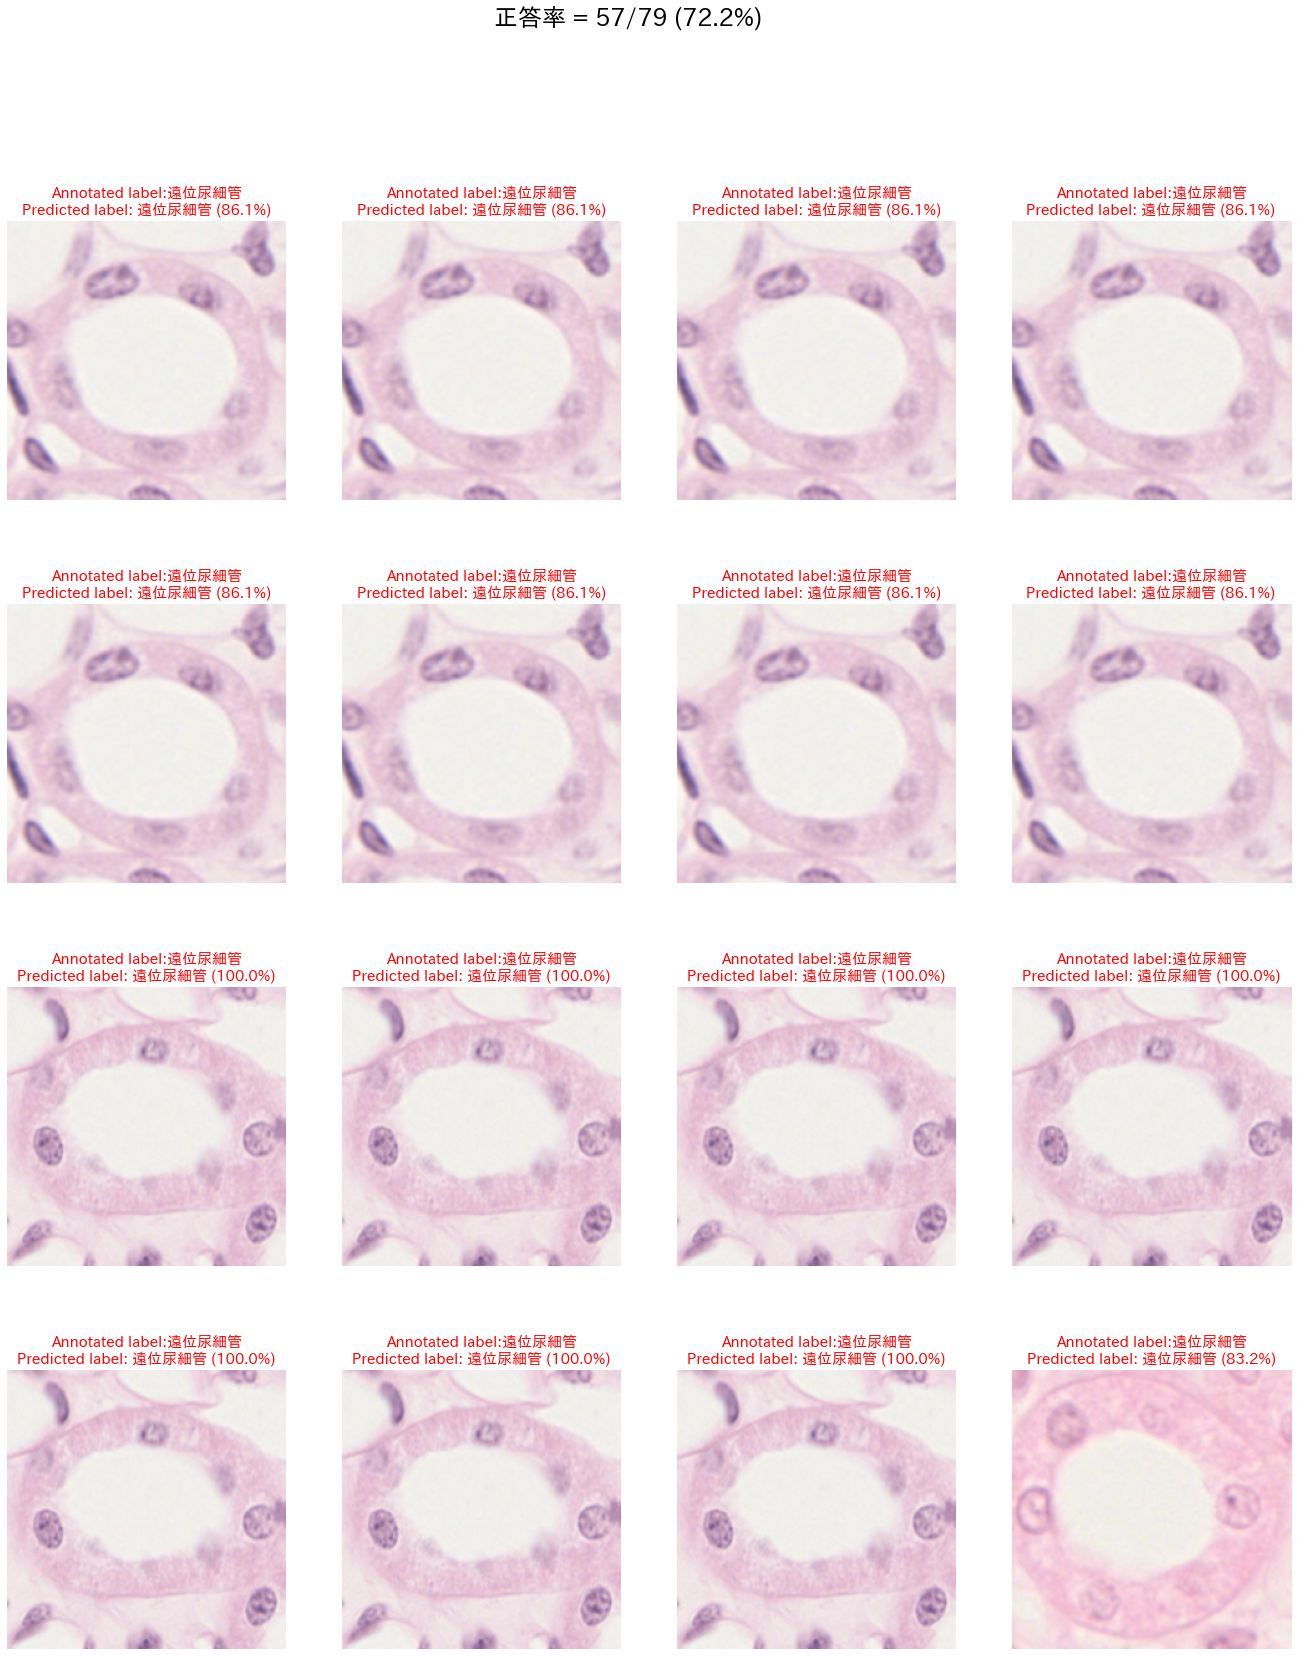

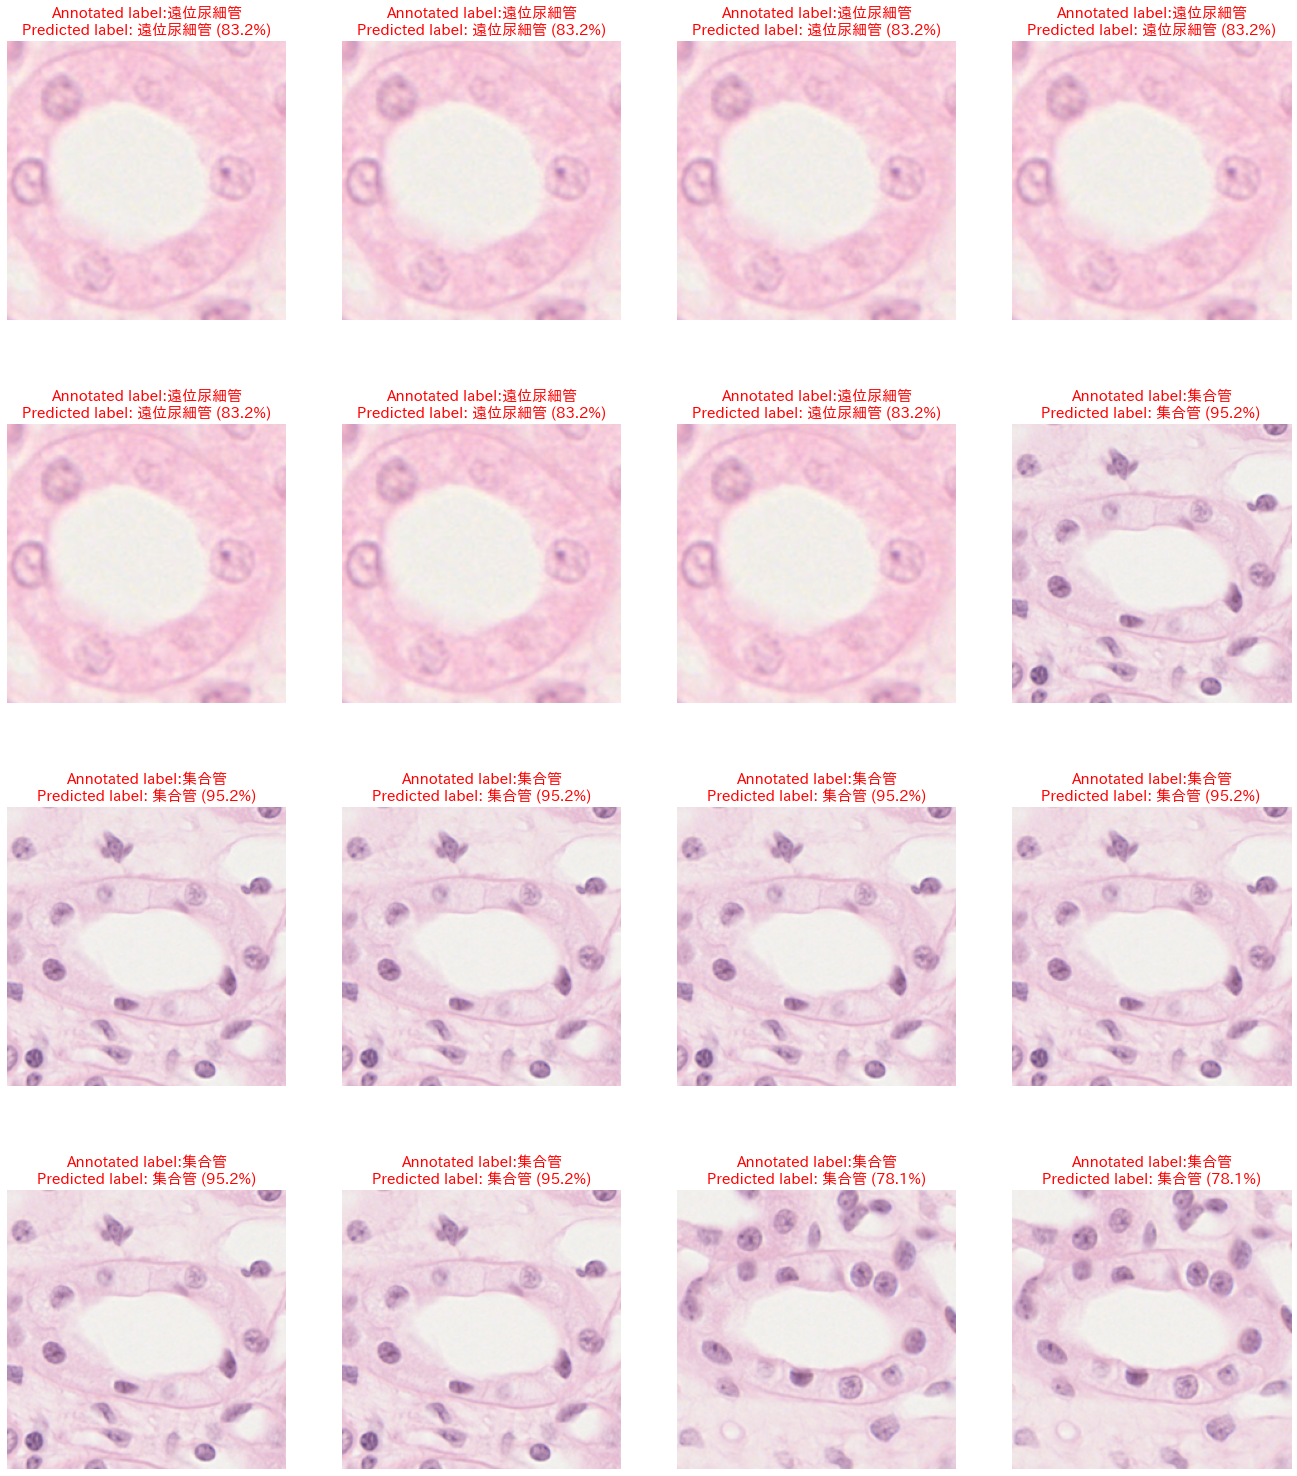

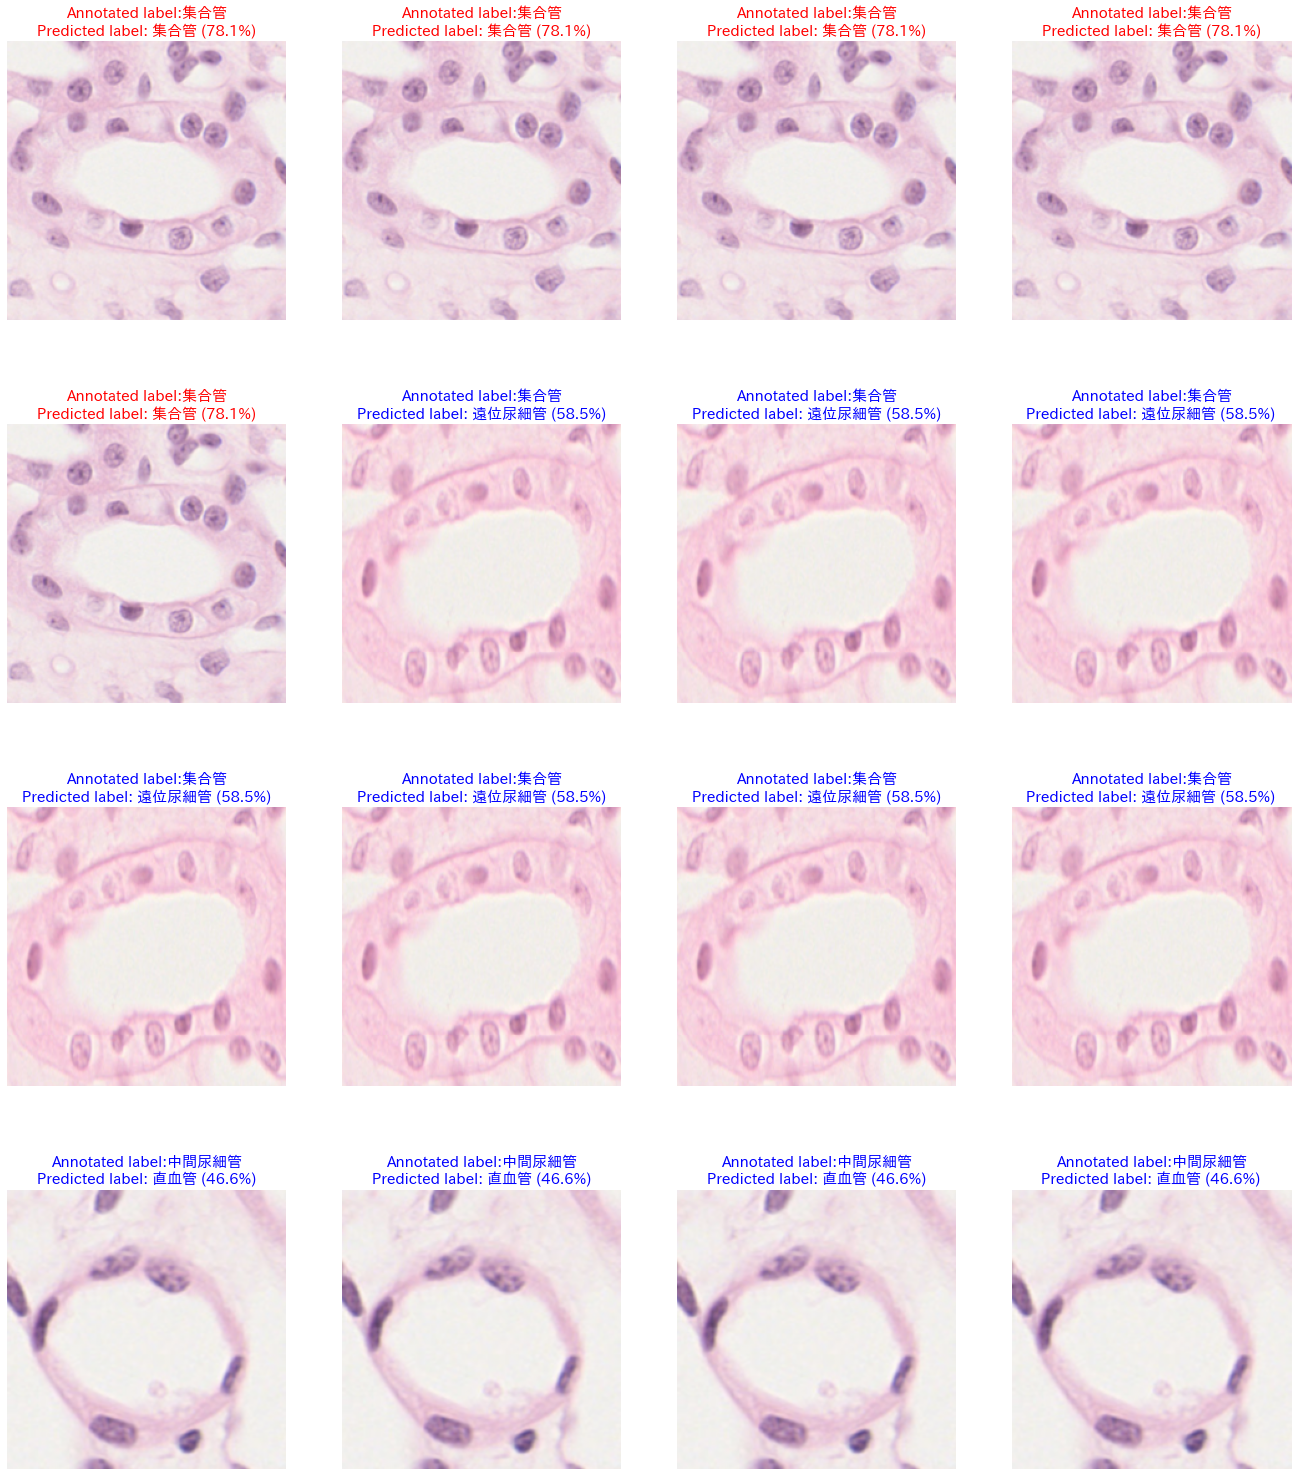

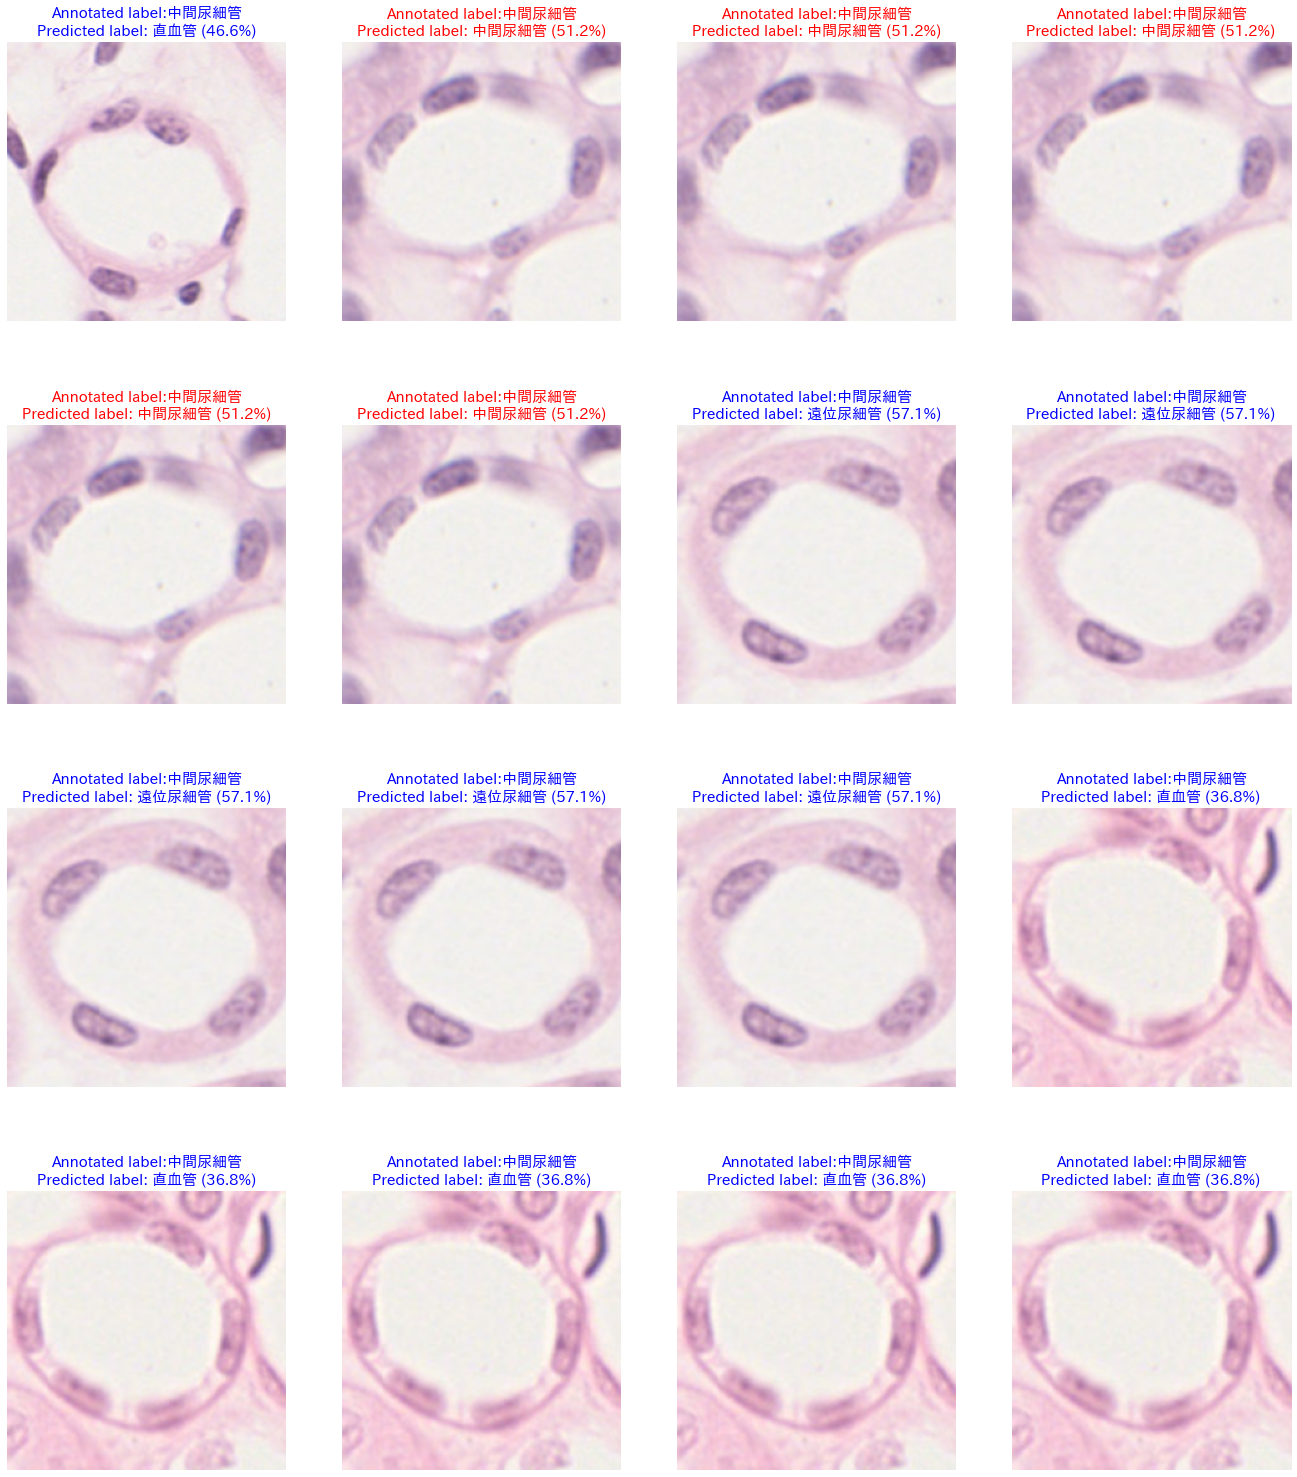

In [ ]:
##組織画像の分類
##学習し、保存したモデルを読み込んで、推測のみを行う
##推論したいデータがフォルダに分類されているパターンと、されてないパターン両方に対応

##ライブラリの読み込み

import itertools
import os
import time
import re

# matplotlib日本語対応バージョン
!pip install japanize_matplotlib
import matplotlib.pyplot as plt
import japanize_matplotlib

# 日本語の濁点が分離してしまう問題に対応
from unicodedata import normalize

import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

from PIL import Image
from decimal import Decimal, ROUND_HALF_UP

###########################################################################################################
#汎用的に使えるようにするためにこの部分に課題ごとに変更が必要になるパラメータを集積する

model_saved_dir = '/content/drive/MyDrive/result' #モデルを保存したフォルダ
test_data_dir = '/content/drive/MyDrive/test' #推論したい画像のフォルダ
save_dir = '/content/drive/MyDrive/result' #jpegファイルを保存するフォルダ
save_file_name = "prediction5.jpg" #出力のjpegの名前。保存する際に上書きされないように、名前を変更できるようにここに設置

Test_images_are_clasified = True #画像を分類済みの場合は"True"。分類していない画像の推測のみの場合は"False"
#############################################################################################################

start_time = time.time()

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

if not os.path.exists(save_dir):
    os.mkdir(save_dir)

scores =[]

##モデルの読み込み
model = tf.keras.models.load_model(model_saved_dir + "/model")
model.summary()

##label情報の読み込み
with open(model_saved_dir + "/label.txt", encoding="utf-8") as label_txt:
    label_list = []
    for i in label_txt:
        label_list.append(i.rstrip('\n'))
        
def image_prediction(image_file):
    ##推測するために、画像を加工
    image_file = image_file.convert("RGB")
    image_file= image_file.resize((224, 224))
    image_file = np.asarray(image_file)
    image_file = image_file.reshape(224, 224, 3)
    image_file = image_file / 255
    
    # Expand the validation image to (1, 224, 224, 3) before predicting the label
    prediction_scores = model.predict(np.expand_dims(image_file, axis=0))
    predicted_index = np.argmax(prediction_scores)
    
    return prediction_scores, predicted_index, image_file

if Test_images_are_clasified:
    folders_list = os.listdir(test_data_dir)
    folders = [f for f in folders_list if os.path.isdir(os.path.join(test_data_dir, f))]
    
    correct = 0
    i = 0
    image_prediction_list = []
        
    for l in range(len(folders)):
        image_files = os.listdir(test_data_dir + '/' + folders[l])
        for m in range(len(image_files)):
            patternStr = '.+\.(jpg|png|PNG|jpeg)'
            pattern = re.compile(patternStr)
            result = pattern.match(image_files[m])
            if result:
                image = Image.open(test_data_dir + '/' + folders[l] + "/" + image_files[m])
                image_prediction_list.append([folders[l], image_files[m]])
                prediction_result = image_prediction(image)
                for n in range(3):
                    image_prediction_list[i].append(prediction_result[n])
                    
                # print(prediction_scores)
                total_score = 0
                predicted_scores = prediction_result[0][0]
                for o in range(len(predicted_scores)):
                    if predicted_scores[o] > 0:
                        total_score += predicted_scores[o]
                        predicted_percentage = Decimal(max(predicted_scores) / total_score * 100).quantize(Decimal('0.0'), rounding=ROUND_HALF_UP)
                image_prediction_list[i].append(predicted_percentage)
                    
                predicted_label = normalize("NFC", label_list[image_prediction_list[i][3]])
                folder_name = normalize("NFC", folders[l])
                    
                image_prediction_list[i].append(predicted_label)
                image_prediction_list[i][0] = folder_name

                if predicted_label == folder_name:
                    image_prediction_list[i].append("red")
                    correct += 1
                else:
                    image_prediction_list[i].append("blue")
                    
                i+=1
                    
 #image_prediction_listは[フォルダ名、画像ファイル名、prediction_score,predicted_index,
 #                         image_file, predicted_percentage, predicted_label, output_color]
                    
    # 予測結果を表示させるための図の作成
    plt.figure(figsize=(23, 27))
        
    # 正答率と画像枚数をタイトルとして表示
    plt.suptitle(
            "正答率 = " + str(correct) + "/" + str(i) + " (" + str(
                Decimal(correct / i * 100).quantize(Decimal('0.0'), rounding=ROUND_HALF_UP)) + "%)",
            fontsize=24)
       
    for p in range(16):
        if p == i:
            break
        else:
            plt.subplot(4, 4, p + 1)
            plt.imshow(image_prediction_list[p][4])
            plt.axis('off')

            # 画像の上に、教員のアノテーションラベルとAIの予測ラベルを表示
            # アノテーションと予測ラベルが合致する場合、赤色で、間違っている場合は青色で表示する
            # 日本語の濁点が分離してしまう問題にも対応
            plt.title(
                "Annotated label:" + image_prediction_list[p][0] + "\nPredicted label: " + image_prediction_list[p][6]
                + " (" + str(image_prediction_list[p][5]) + "%)", fontsize=15, color= image_prediction_list[p][7])
    #jpegで保存
    plt.savefig(save_dir + "/" + save_file_name)

        
        
    #２枚目以降のプロット
    additional_page = 1
    jpg_index = save_file_name.find(".jpg")
        
    while (i-(additional_page)*16) > 1:
        plt.figure(figsize=(23, 27))
        for p in range(16):
            actual_i = p+16*(additional_page)
            if actual_i == i:
                break
            else:
                plt.subplot(4, 4, p+1)
                plt.imshow(image_prediction_list[actual_i][4])
                plt.axis('off')

                # 画像の上に、教員のアノテーションラベルとAIの予測ラベルを表示
                # アノテーションと予測ラベルが合致する場合、赤色で、間違っている場合は青色で表示する
                # 日本語の濁点が分離してしまう問題にも対応
                plt.title(
                       "Annotated label:" + image_prediction_list[actual_i][0] + "\nPredicted label: " + image_prediction_list[actual_i][6]
                        + " (" + str(image_prediction_list[actual_i][5]) + "%)", fontsize=15, color= image_prediction_list[actual_i][7])
                
        #jpegで保存
        plt.savefig(save_dir + "/" + save_file_name[:jpg_index] + "-" + str(additional_page+1) + save_file_name[jpg_index:])
        additional_page += 1
        
        
    # 点数の保存
    print(" Accuracy: " + str(Decimal(correct / i *100).quantize(Decimal('0.0'), rounding=ROUND_HALF_UP) )+ "% ")
    elapsed_time = time.time() - start_time
    print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")
            
        

else:
    i = 0
    image_prediction_list = []
    image_files = os.listdir(test_data_dir)
    for m in range(len(image_files)):
        patternStr = '.+\.(jpg|jpeg|png|PNG)'
        pattern = re.compile(patternStr)
        result = pattern.match(image_files[m])
            
        if result:
            image = Image.open(test_data_dir + "/" + image_files[m])
            image_prediction_list.append(["null", image_files[m]])
            prediction_result = image_prediction(image)
            for n in range(3):
                image_prediction_list[i].append(prediction_result[n])
                    
            total_score = 0
            predicted_scores = prediction_result[0][0]
            for o in range(len(predicted_scores)):
                if predicted_scores[o] > 0:
                      total_score += predicted_scores[o]
                      predicted_percentage = Decimal(max(predicted_scores) / total_score * 100).quantize(Decimal('0.0'), rounding=ROUND_HALF_UP)
            image_prediction_list[i].append(predicted_percentage) 
                
            predicted_label = normalize("NFC", label_list[image_prediction_list[i][3]])
            image_prediction_list[i].append(predicted_label)
                
#image_prediction_listは["null"、画像ファイル名、prediction_score,predicted_index,
#                       image_file, predicted_percentage, predicted_label]
            i+=1
        
    # 予測結果を表示させるための図の作成  
    plt.figure(figsize=(23, 27))
        

    for p in range(16):
        if p == i:
            break
        else:
            plt.subplot(4, 4, p + 1)
            plt.imshow(image_prediction_list[p][4])
            plt.axis('off')
            #　画像の下に画像名を表示
            #plt.set_xlabel(image_prediction_list[p][1])

            # 画像の上に、AIの予測ラベルを表示
            # 日本語の濁点が分離してしまう問題にも対応
            plt.title(
                    image_prediction_list[p][1]
                    + "\nPredicted label: " + image_prediction_list[p][6]
                    + " (" + str(image_prediction_list[p][5]) + "%)", fontsize=15)
    #jpegで保存
    plt.savefig(save_dir + "/" + save_file_name)
        
    #２枚目以降のプロット
    additional_page = 1
    jpg_index = save_file_name.find(".jpg")
        
    while (i-(additional_page)*16) > 1:
        plt.figure(figsize=(23, 27))
        for p in range(16):
            actual_i = p+16*(additional_page)
            if actual_i == i:
                break
            else:
                plt.subplot(4, 4, p+1)
                plt.imshow(image_prediction_list[actual_i][4])
                plt.axis('off')
                #　画像の下に画像名を表示
                #plt.set_xlabel(image_prediction_list[p][1])

                # 画像の上に、AIの予測ラベルを表示
                # 日本語の濁点が分離してしまう問題にも対応
                plt.title(
                    image_prediction_list[actual_i][1]
                    + "\nPredicted label: " + image_prediction_list[actual_i][6]
                      + " (" + str(image_prediction_list[actual_i][5]) + "%)", fontsize=15)
                
        #jpegで保存
        plt.savefig(save_dir + "/" + save_file_name[:jpg_index] + "-" + str(additional_page+1) + save_file_name[jpg_index:])
        additional_page += 1


    elapsed_time = time.time() - start_time
    print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

        